<a href="https://colab.research.google.com/github/qmeng222/MNIST-Playground/blob/main/shifted_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [27]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',') # numpy array

# extract labels, then drop labels from data:
labels = data[:,0] # extract
data   = data[:,1:] # drop

# normalize (both train & test) data to [0 1]:
dataNorm = data / np.max(data)

In [28]:
# Step 1: convert to PyTorch tensors
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data (still tensors):
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)
print(train_data.shape,test_data.shape, train_labels.shape,test_labels.shape)

# Step 3: PyTorch tensors -> PyTorch TensorDataset objects:
# combine data and label tensors into a single dataset object
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: PyTorch TensorDataset objects -> PyTorch dataloader objects
# shuffle the data to help model generalize better
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # batch_size=2000

torch.Size([18000, 784]) torch.Size([2000, 784]) torch.Size([18000]) torch.Size([2000])


In [29]:
# scratch paper:
print(test_data.tensors, "\n") # tuple
print(test_data.tensors[0], "\n")
print(test_data.tensors[0].shape)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([6, 1, 7,  ..., 9, 0, 4])) 

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) 

torch.Size([2000, 784])


# Shift (the cols of) the test images by a few pixels:

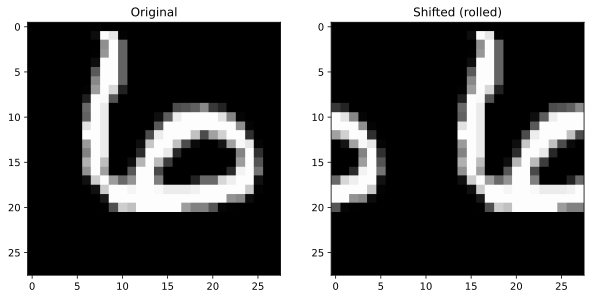

In [33]:
tmp = test_loader.dataset.tensors[0][0,:] # grab the 1st test image
tmp = tmp.reshape(28,28) # reshape it to 2D

# shift the image (pytorch calls it "rolling")
tmpS = torch.roll(tmp,8,dims=1) # or dims=0

# now show them both:
fig,ax = plt.subplots(1,2,figsize=(10,6))

ax[0].set_title('Original')
ax[0].imshow(tmp, cmap='gray')

ax[1].set_title('Shifted (rolled)')
ax[1].imshow(tmpS, cmap='gray')

plt.show()

👇NOTE: scramble images (train & test) will not affect categorization performance (as we previously proved).

In [35]:
# (leaving training images as-is) shift all test images:

# access data inside the dataloader obj:
for i in range(test_loader.dataset.tensors[0].shape[0]): # iterate over 2000 images
  img = test_loader.dataset.tensors[0][i,:] # the ith image

  # reshape and shift the image horizontally:
  randroll = np.random.randint(-10,11) # rolling by a random number of pixels from -10 to 10
  img = torch.roll( img.reshape(28,28) ,randroll,dims=1 ) # shift horizontally

  # reshapes the image into a 1-row tensor, the "-1" value is a placeholder:
  test_loader.dataset.tensors[0][i,:] = img.reshape(1,-1)

In [36]:
def createTheMNISTNet():

  # model class:
  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [37]:
# a function that trains the model:

def function2trainTheModel():

  # number of epochs
  numepochs = 50

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader))
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [38]:
# run the function to train the model:
trainAcc,testAcc,losses,net = function2trainTheModel()

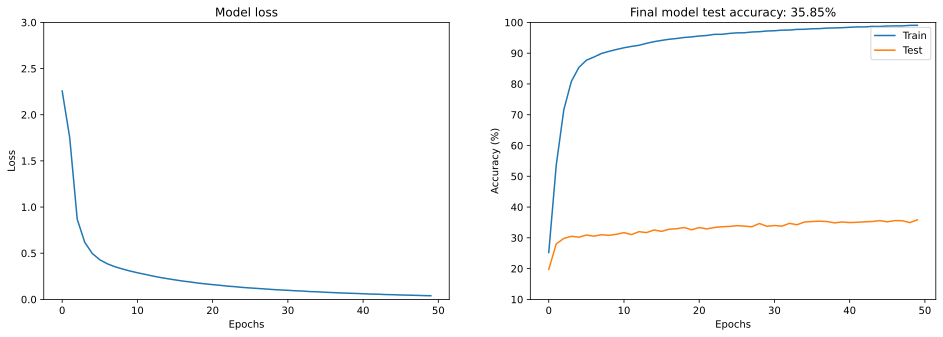

In [39]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

**Observations:**
*   Loss function goes down as expected.
*   Test accuracy for the training images is fine.
*   But with MNIST, the test accuracy is horrible (the model is simply not learning to generalize to test images).
*   Although the test accuracy (~30%) is still better than the chance performance (10% theoretically).

---
**Conclusion:**
Scramble the pixels has zero effect on categorization performance (as we previously proved), but shifting has hugely negative impact on model performance (that's a key limitaton of FFNs for image processing, which motivates the use of CNNs).